In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import requests
import urllib.request
from bs4 import BeautifulSoup as bs


In [2]:
urls = ["https://www.imdb.com/search/title/?count=100&groups=oscar_best_picture_winners&sort=year,desc&ref_=nv_ch_osc"]

In [3]:
contraction_map = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [4]:
# Loop through the two URLs, retrieve the links with 'href' tags. Store them in the list 'links'
links = {}
for url in urls:
    response = requests.get(url)
    soup = bs(response.text, "html.parser")
    #elements = soup.find_all("div", class_="lister-item-image float-left".split())
    elements = soup.findAll("div", {"class": "lister-item-content"})
    for element in elements:
        #print (element)
        name = element.find('a').contents[0]
        link = "https://imdb.com"+element.find('a')['href'] 
        rating = element.find("strong").contents[0]
        genre = element.find('span', {'class' : 'genre'}).contents[0]
        if float(rating) >= 8.5:
            label = "Positive"
        elif float(rating) >=6.5 and float(rating) <8.5:
            label = "Neutral"
        else:
            label = "Negative"
        
        links.update({name: [link, rating, label, genre]})

In [5]:
first5pairs = {k: links[k] for k in list(links)[:5]}
print (first5pairs)

{'The Best Years of Our Lives': ['https://imdb.com/title/tt0036868/', '8.1', 'Neutral', '\nDrama, Romance, War            '], '12 Years a Slave': ['https://imdb.com/title/tt2024544/', '8.1', 'Neutral', '\nBiography, Drama, History            '], 'The French Connection': ['https://imdb.com/title/tt0067116/', '7.7', 'Neutral', '\nAction, Crime, Drama            '], 'The Great Ziegfeld': ['https://imdb.com/title/tt0027698/', '6.8', 'Neutral', '\nBiography, Drama, Musical            '], 'An American in Paris': ['https://imdb.com/title/tt0043278/', '7.2', 'Neutral', '\nDrama, Musical, Romance            ']}


In [6]:
user_reviews = {}
for name, url in links.items():
    response = requests.get(url[0])
    soup = bs(response.text, "html.parser")
    comments = soup.find_all("div", class_="user-comments".split())
    user_comments = [comment.find('p').text for comment in comments]
    user_reviews.update({name: url+user_comments})

In [7]:
first2pairs = {k: user_reviews[k] for k in list(user_reviews)[:2]}
print (first2pairs)

{'The Best Years of Our Lives': ['https://imdb.com/title/tt0036868/', '8.1', 'Neutral', '\nDrama, Romance, War            ', 'My parents were of that generation, and the movie was cathartic for returning veterans and their families and friends; it\'s small wonder that it eclipsed <i>It\'s A Wonderful Life</i>, which arguably is a better picture. But at the time, the movie had some shocking elements to it. In fact, my mother (roughly the character Peggy\'s age then) saw it against her parents\' wishes.Back in 1946, it was a jaw-dropper to have a character in a movie utter the word "divorce" or to aver an intent to break up a marriage -- such ideas just weren\'t voiced in films then. To modern audiences, they come across as melodramatic, but I\'m told they elcited genuine gasps from audiences then.Even more astonishing was William Wyler\'s decision to cast real-life amputee Harold Russell in the key role of a returning Navy veteran. Until <i>The Battle of Britain</i>, in which an actual,

In [8]:
data = []
for key, values in user_reviews.items():
    value = str(values[4])
    data.append(value)

In [9]:
# # Expanding Contractions
def expand_contractions(text, contraction_mapping=contraction_map):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) \
                                   if contraction_mapping.get(match) \
                                    else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [10]:
def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wn.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

In [11]:
from pattern.en import tag
from nltk.corpus import wordnet as wn
# Annotate text tokens with POS tags
def pos_tag_text(text):
    # convert Penn treebank tag to wordnet tag
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
    tagged_text = tag(text)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text

In [12]:
# lemmatize text based on POS tags
def lemmatize_text(text):
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag else word
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [13]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = expand_contractions(doc)  
    doc = lemmatize_text(doc)
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    filtered_tokens = remove_repeated_characters(filtered_tokens)
    filtered_tokens = [ss.stem(t) for t in filtered_tokens]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [14]:
import nltk

stop_words = nltk.corpus.stopwords.words('english')
normalize_corpus = np.vectorize(normalize_document)

In [15]:
import re
from nltk.corpus import wordnet as wn
from nltk.stem import SnowballStemmer
ss = SnowballStemmer("english")
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

norm_corpus = normalize_corpus(list(data))
len(norm_corpus)

92

In [16]:
norm_corpus

array(['parent generat movi cathart return veteran famili friend small wonder eclips it wonder lifei arguabl good pictur time movi shock element fact mother rough charact pegi age saw parent wishesback 1946 jawdrop charact movi utter word divorc aver intent break marriag idea werent voic film modern audienc come across melodramat im tell elcit genuin gasp audienc theneven astonish wiliam wyler decis cast realif ampute harold russel key role return navi veteran ith battl britaini actual disfigur raf veteran make cameo appear director didnt make sort courag gestur intim yet innoc scene homer parrish russel demonstr helpless fianc wilma cameron cathi odonel beauti heartbreak uplift later wed scene russel stumbl line say vow wyler leav human mistak god bless',
       'read award circuit htpwawardscircuitcomon thing throw around month notion award season vote bodi wont respond difficult sit let defin difficult shal difficult see first open gay politician gun closet colleagu difficult see re

In [17]:
NUM_TOPICS = 10
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')

data_vectorized = vectorizer.fit_transform(norm_corpus)
 
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)
#print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

In [18]:
print ("=-=-=-=-= Latent Dirichlet Allocation =-=-=-=-=-=")
# Log Likelihood Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

=-=-=-=-= Latent Dirichlet Allocation =-=-=-=-=-=
Log Likelihood:  -50725.08615825625
Perplexity:  573.9525888137375
{'n_topics': None, 'max_iter': 10, 'topic_word_prior': None, 'n_components': 10, 'perp_tol': 0.1, 'n_jobs': None, 'doc_topic_prior': None, 'learning_offset': 10.0, 'total_samples': 1000000.0, 'learning_decay': 0.7, 'mean_change_tol': 0.001, 'evaluate_every': -1, 'random_state': None, 'max_doc_update_iter': 100, 'batch_size': 128, 'learning_method': 'online', 'verbose': 0}


In [19]:
estimators = {'lda': LatentDirichletAllocation()}

n_components = [5, 10, 15, 20, 25, 30]
learning_decay = [.5, .7, .9]
learning_offset = [1., 2., 3., 4., 5., 6., 7., 8., 9.]
solver = ['cd', 'mu']
max_iter = [25, 50, 100, 125, 150, 175, 200]

lda_param = dict (n_components = n_components,
                 learning_decay = learning_decay,
                 learning_offset = learning_offset)

nmf_param = dict (n_components = n_components,
                  solver = solver,
                  max_iter = max_iter
                 )

params_grid = {'lda': lda_param}

In [20]:
def performGridorRandomSearch(search_type, data_vectorized):
    n_iter_search = 20
    for name in estimators.keys():
        estimator = estimators[name]
        param_grid = params_grid[name]
        if search_type == 'R':
            grscv = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, n_iter = n_iter_search, cv=5)
        else:
            grscv = GridSearchCV(estimator=estimator, param_grid=param_grid)
        try:
            grscv.fit(data_vectorized)
            
            report(grscv.cv_results_)
            best_lda_model = grscv.best_estimator_
            print("best parameters are: {}".format(grscv.best_estimator_))
            print("Model Perplexity: ", grscv.best_estimator_.perplexity(data_vectorized))
        except ValueError:
            print('-*-*-*-*-*-*- Hyper Parameter Combination Doesnot Exists:-*-*-*-*-*-*- ', param_grid)   
        
    return()

In [21]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Log Likelihood Score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [22]:
performGridorRandomSearch("G", data_vectorized)

Model with rank: 1
Log Likelihood Score: -18292.199 (std: 1397.674)
Parameters: {'learning_offset': 4.0, 'learning_decay': 0.7, 'n_components': 5}

Model with rank: 2
Log Likelihood Score: -18325.247 (std: 1254.139)
Parameters: {'learning_offset': 4.0, 'learning_decay': 0.5, 'n_components': 5}

Model with rank: 3
Log Likelihood Score: -18338.057 (std: 1091.325)
Parameters: {'learning_offset': 5.0, 'learning_decay': 0.5, 'n_components': 5}

best parameters are: LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=4.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
Model Perplexity:  449.71751714324023


()

In [23]:
performGridorRandomSearch("R", data_vectorized)

Model with rank: 1
Log Likelihood Score: -11892.515 (std: 857.715)
Parameters: {'learning_offset': 1.0, 'learning_decay': 0.9, 'n_components': 5}

Model with rank: 2
Log Likelihood Score: -11910.234 (std: 783.831)
Parameters: {'learning_offset': 4.0, 'learning_decay': 0.9, 'n_components': 5}

Model with rank: 3
Log Likelihood Score: -11974.002 (std: 733.151)
Parameters: {'learning_offset': 5.0, 'learning_decay': 0.7, 'n_components': 5}

best parameters are: LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='batch', learning_offset=1.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
Model Perplexity:  442.70308850241986


()

In [24]:
lda_model = LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='batch', learning_offset=5.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
lda_model.fit(data_vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='batch', learning_offset=5.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [25]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'lda.html')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics          x          y
topic                                                  
2      36.634401        1       1  99.446289 -73.564064
4      30.539331        1       2  68.526016 -11.706118
0      16.493489        1       3  32.043606 -97.541580
3       8.734141        1       4 -16.949257 -49.022144
1       7.598639        1       5   6.370236  18.610632, topic_info=     Category        Freq     Term       Total  loglift  logprob
term                                                            
174   Default  374.000000     film  374.000000  30.0000  30.0000
299   Default  136.000000     movi  136.000000  29.0000  29.0000
442   Default   91.000000    stori   91.000000  28.0000  28.0000
271   Default  134.000000     make  134.000000  27.0000  27.0000
328   Default   58.000000  perform   58.000000  26.0000  26.0000
44    Default   71.000000     best   71.000000  25.0000  25.0000
194   Default   72.000000    great   72.000000  24.0000  24.0000
246   Default   16.000000     king   16.000000  23.0000  23.0000
503   Default   45.000000      way   45.000000  22.0000  22.0000
321   Default   32.000000    oscar   32.000000  21.0000  21.0000
369   Default   45.000000   realli   45.000000  20.0000  20.0000
7     Default   51.000000    actor   51.000000  19.0000  19.0000
500   Default   32.000000      war   32.000000  18.0000  18.0000
384   Default   16.000000   return   16.000000  17.0000  17.0000
100   Default   12.000000     danc   12.000000  16.0000  16.0000
149   Default   31.000000    everi   31.000000  15.0000  15.0000
285   Default   18.000000      men   18.000000  14.0000  14.0000
263   Default   26.000000     look   26.000000  13.0000  13.0000
173   Default   18.000000    fight   18.000000  12.0000  12.0000
327   Default   34.000000  perfect   34.000000  11.0000  11.0000
492   Default   16.000000  version   16.000000  10.0000  10.0000
72    Default   89.000000  charact   89.000000   9.0000   9.0000
304   Default   33.000000      new   33.000000   8.0000   8.0000
448   Default   11.000000    subtl   11.000000   7.0000   7.0000
335   Default   61.000000     play   61.000000   6.0000   6.0000
199   Default   20.000000   happen   20.000000   5.0000   5.0000
468   Default   90.000000     time   90.000000   4.0000   4.0000
254   Default   16.000000      let   16.000000   3.0000   3.0000
143   Default   13.000000     epic   13.000000   2.0000   2.0000
306   Default   15.000000    night   15.000000   1.0000   1.0000
...       ...         ...      ...         ...      ...      ...
13     Topic5    2.366155   affect    8.337446   1.3177  -5.5469
461    Topic5    2.349539    thank    8.298813   1.3153  -5.5539
363    Topic5    2.560661     rate    9.175072   1.3010  -5.4679
51     Topic5    2.076219      box    7.453509   1.2991  -5.6776
422    Topic5    2.787293   social   10.169393   1.2829  -5.3830
223    Topic5    1.907225   imposs    7.352636   1.2278  -5.7625
263    Topic5    6.747806     look   26.856830   1.1959  -4.4989
328    Topic5   13.568387  perform   58.371068   1.1181  -3.8004
149    Topic5    7.425649    everi   31.691508   1.1261  -4.4032
503    Topic5    9.724223      way   45.754854   1.0285  -4.1335
327    Topic5    7.663184  perfect   34.452884   1.0740  -4.3717
508    Topic5    3.658973    woman   14.949438   1.1697  -5.1109
140    Topic5    4.821005    enjoy   23.313459   1.0012  -4.8351
271    Topic5   16.055996     make  134.400135   0.4525  -3.6320
369    Topic5    7.602594   realli   45.491130   0.7882  -4.3796
194    Topic5   10.185222    great   72.538252   0.6140  -4.0872
442    Topic5    9.822770    stori   91.639358   0.3440  -4.1234
299    Topic5   11.079353     movi  136.363689   0.0670  -4.0030
72     Topic5    8.863714  charact   89.086178   0.2696  -4.2262
335    Topic5    7.228601     play   61.415118   0.4376  -4.4301
468    Topic5    8.383854     time   90.091991   0.2027  -4.2818
171    Topic5    5.367304     feel   34.417371   0.7190

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;

num_topics = 5;

In [27]:
transformer = TfidfTransformer(smooth_idf=False)
x_tfidf = transformer.fit_transform(data_vectorized)
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)
model = NMF(n_components=num_topics, init='nndsvd', random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5)
model.fit(xtfidf_norm)

NMF(alpha=0.1, beta_loss='kullback-leibler', init='nndsvd', l1_ratio=0.5,
  max_iter=1000, n_components=5, random_state=1, shuffle=False,
  solver='mu', tol=0.0001, verbose=0)

In [28]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'nmf.html')

In [29]:
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x          y
topic                                                   
0      57.467232        1       1   30.839720 -71.927406
1      17.155649        1       2  106.905586 -42.153805
3      10.311050        1       3  113.285019  42.357372
4       9.978809        1       4  -31.222733 -14.213368
2       5.087260        1       5   31.450739  38.544647, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
299   Default   95.000000        movi   95.000000  30.0000  30.0000
174   Default  149.000000        film  149.000000  29.0000  29.0000
255   Default   65.000000        life   65.000000  28.0000  28.0000
53    Default   42.000000   brilliant   42.000000  27.0000  27.0000
194   Default   67.000000       great   67.000000  26.0000  26.0000
468   Default   74.000000        time   74.000000  25.0000  25.0000
327   Default   36.000000     perfect   36.000000  24.0000  24.0000
271   Default   81.000000        make   81.000000  23.0000  23.0000
509   Default   35.000000      wonder   35.000000  22.0000  22.0000
395   Default   61.000000       scene   61.000000  21.0000  21.0000
5     Default   47.000000         act   47.000000  20.0000  20.0000
326   Default   38.000000       peopl   38.000000  19.0000  19.0000
257   Default   65.000000        like   65.000000  18.0000  18.0000
328   Default   64.000000     perform   64.000000  17.0000  17.0000
44    Default   57.000000        best   57.000000  16.0000  16.0000
225   Default   27.000000      includ   27.000000  15.0000  15.0000
445   Default   34.000000      strong   34.000000  14.0000  14.0000
247   Default   36.000000        know   36.000000  13.0000  13.0000
141   Default   28.000000   entertain   28.000000  12.0000  12.0000
154   Default   33.000000       excel   33.000000  11.0000  11.0000
439   Default   25.000000       start   25.000000  10.0000  10.0000
274   Default   34.000000        mani   34.000000   9.0000   9.0000
464   Default   28.000000       thing   28.000000   8.0000   8.0000
316   Default   25.000000         old   25.000000   7.0000   7.0000
406   Default   17.000000     sequenc   17.000000   6.0000   6.0000
7     Default   45.000000       actor   45.000000   5.0000   5.0000
108   Default   23.000000     definit   23.000000   4.0000   4.0000
503   Default   49.000000         way   49.000000   3.0000   3.0000
517   Default   40.000000        year   40.000000   2.0000   2.0000
494   Default   26.000000      viewer   26.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
53     Topic5   22.872166   brilliant   42.994758   2.3473  -2.8770
61     Topic5    7.724674        care   15.843248   2.2601  -3.9625
343    Topic5    2.104016     possibl    4.494433   2.2194  -5.2630
195    Topic5    2.966194       group    6.443820   2.2026  -4.9196
144    Topic5    4.391758       equal    9.596397   2.1968  -4.5272
337    Topic5    2.941842    poignant    6.483790   2.1882  -4.9279
239    Topic5    5.078051         job   11.418788   2.1681  -4.3820
206    Topic5    4.845529  heartbreak   11.193575   2.1411  -4.4288
108    Topic5    9.696343     definit   23.977343   2.0731  -3.7351
495    Topic5    1.598678     villain    3.954728   2.0727  -5.5377
509    Topic5   13.953170      wonder   35.836338   2.0352  -3.3712
64     Topic5    2.545716        case    6.741132   2.0046  -5.0725
93     Topic5    2.856815      costum    7.652353   1.9931  -4.9572
6      Topic5    4.249197      action   11.876948   1.9506  -4.5602
276    Topic5    5.210011  masterpiec   14.799236   1.9344  -4.3563
141    Topic5    9.492500   entertain   28.032833   1.8956  -3.7564
485    Topic5    6.760914        true   20.932229   1.8483  -4.0957
214    Topic5    5.015417   hollywood   15.539384   1.8476  -4.3944
55     Topic5    4.154277     british   12.920930   1.8437  -4.5828
236    Topic5    6.788

In [30]:
# Singular Value Decomposition 
import pandas as pd
import bokeh
from bokeh.io import push_notebook, show, output_notebook
import bokeh.plotting as bp
from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource, LabelSet, HoverTool
output_notebook()

svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(x_tfidf.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=1200, plot_height=1000)
plot.circle("x", "y", size=8, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)

try:
    show(plot, notebook_handle=True)
except Exception as e:
    print('Note!: {}'.format(e.__doc__))
    print(e)

Loading BokehJS ...

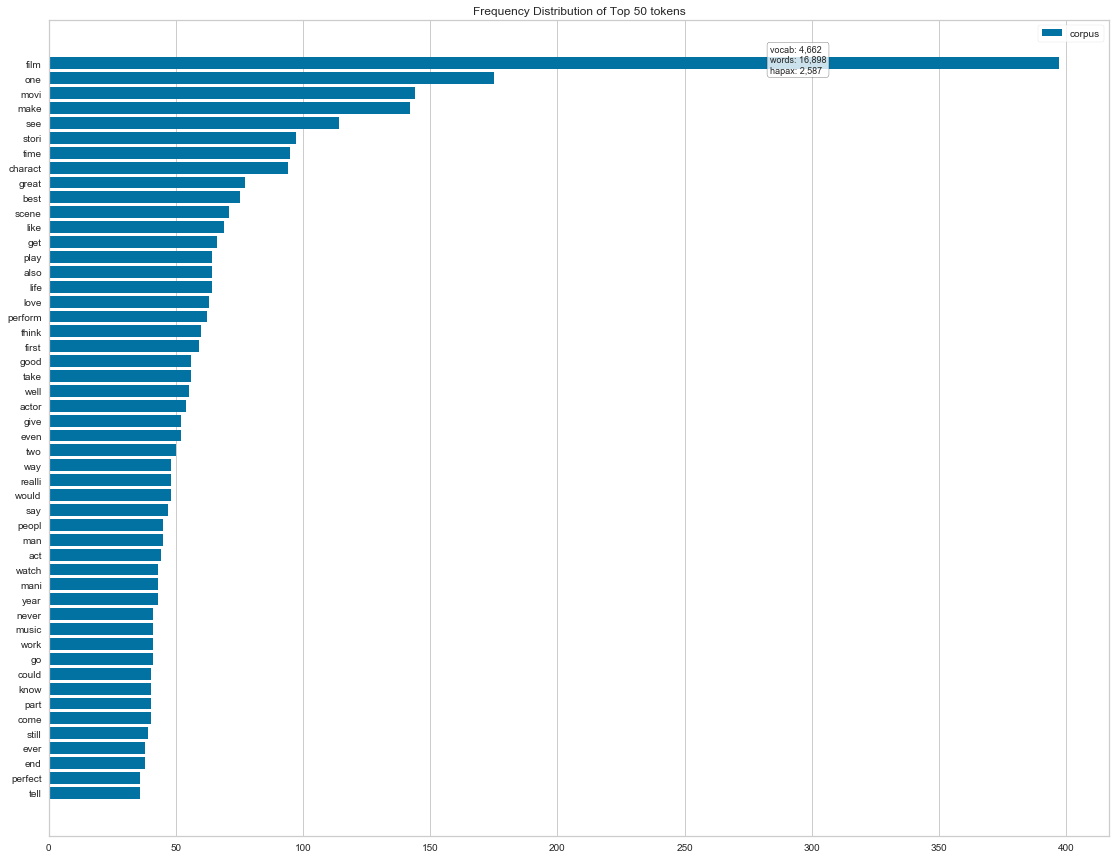

In [38]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(norm_corpus)
features   = vectorizer.get_feature_names()

fig = plt.figure(figsize=(19, 15))

visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

In [40]:
feat_names = vectorizer.get_feature_names()
word_dict = {};
for i in range(5):
    words_ids = model.components_[i].argsort()[:-20 - 1:-1]
    words = [feat_names[key] for key in words_ids]
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;

In [41]:
word_dict

{'Topic # 01': ['2dvd',
  'appeal',
  'african',
  'bear',
  'benefit',
  'anglosaxon',
  'anniversari',
  'artist',
  'alejandro',
  'antholog',
  'alec',
  'bind',
  'awkward',
  'accompani',
  'bemus',
  'arous',
  'audrey',
  'antibligh',
  'aylmer',
  'billi'],
 'Topic # 02': ['african',
  'behav',
  '16th',
  'arous',
  'biograph',
  'angharad',
  '20s',
  '197',
  'beliefs',
  'afoul',
  '33rd',
  'accomplish',
  'adjust',
  'answer',
  'biopic',
  'atyp',
  'aristocraci',
  '195',
  'anguish',
  'apollo'],
 'Topic # 03': ['appeal',
  '1986',
  'around',
  'angharad',
  'birch',
  'alejandro',
  '15',
  'bafta',
  'arnold',
  'abyss',
  'actorthat',
  'arous',
  'alorigin',
  'amazon',
  'angri',
  'anderson',
  'alabama',
  '202',
  'amount',
  'amon'],
 'Topic # 04': ['amadeus',
  'benefit',
  'anglosaxon',
  'bay',
  'argo',
  'belydanc',
  'antholog',
  'baruchel',
  'afflict',
  'baxter',
  'blair',
  'abyss',
  'abraham',
  'aliv',
  'ali',
  '180',
  'await',
  '400',
  '